# Model Description

This notebook describes the creation of the RR Lyrae model. For usage examples see the `demo_R.ipynb` and `demo_python.ipynb` notebooks.

## Model Form

The form for the RR Lyrae model is
$$ m_b(t) = \mu + M_b(\omega) + E[B-V]R_b + a \gamma_b(\omega t + \phi)$$
where the population parameters, common to all RR Lyrae, are:
\begin{align*}
  M_b(\omega) &= \text{ ab. magnitude in band b for an RR Lyrae with frequency } \omega\\
  R_b &= \text{extinction law in band b}\\
  \gamma_b &= \text{the shape of the RR Lyrae light curve in band b}
\end{align*}

The object specific parameters, different for each RR Lyrae, are
\begin{align*}
  \mu &= \text{distance modulus}\\
  E[B-V] &= \text{amount of dust}\\
  a &= \text{amplitude}\\
  \omega &= \text{frequency}\\
  \phi &= \text{ phase}
\end{align*}

For one RR Lyrae we observe photometry $\{\{t_{bi},m_{bi},\sigma_{bi}\}_{i=1}^{n_b}\}_{b=1}^B$ where $m_{bi}$ is the observed magnitude at time $t_{bi}$ in filter $b$ measured with (known) uncertainty $\sigma_{bi}$. The bands are indexed $1,\ldots,B$ instead of typical letters e.g. ugriz. The model and data are related by
$$m_{bi} = m_b(t_{bi}) + \epsilon_{bi}$$
where $\epsilon_{bi} \sim N(0,\sigma_{bi}^2)$. More generally we could view $\epsilon_{bi}$ as a mean $0$ random variable with $Var(\epsilon_{bi}) = \sigma_{bi}^2$. We discuss these modeling asssumptions in more detail in the Estimating Object Parameters section of this note.

This model assumes all RR Lyrae share a common shape by band and that RR Lyrae are strictly periodic functions. These assumptions are an approximation. For example, RR Lyrae which undergo the Blazhko effect are not strictly periodic functions. Rather than construct a perfectly accurate model, the goal is to construct a model with few free parameters that provides a better approximation to RR Lyrae variation than existing methods. For example a simple sinusoid model fit to 5 filters has a total of 16 free parameters (5 means, 5 amplitudes, 5 phases, and 1 frequency) while providing only a very rough approximation to the steep rise and slow decline in brighness observed in RR Lyrae light curves. In contrast this model provides a significantly better approximation while fitting for 5 free parameters (or 4 if light curves are dust corrected). We provide empirical evidence to support these claims in our results section. 

## Estimating Population Parameters

We estimate the population parameters from theory and existing data sets. The file:

`code/make_template/make_template.R`

in the rr-model repository contains code for doing this. Here we summarize the process and where the parameters are stored.

In [83]:
## load libraries
import numpy as np
import rpy2.robjects as robjects
from rpy2.robjects.vectors import IntVector, FloatVector, StrVector, BoolVector
import rpy2.robjects.numpy2ri as rpyn
import csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('ggplot')
import itertools

In [84]:
## load templates
r=robjects.r
r.load("template_sdss.RData") ## loads r.tem, see later code for usage
r.load("template_des.RData") ## loads r.tem, see later code for usage

R object with classes: ('character',) mapped to:
<StrVector - Python:0x7f79f66a8408 / R:0x311cd38>
['tem_des']

### $R_b$

The extinction values $R_b$ are derived from <strong data-cite="fitzpatrick1999">(Fitzpatrick, 199)</strong>. The extinction values $R_b$ for SDSS filters are:

In [85]:
print(r.tem_sdss[0])

    g     i     r     u     z 
3.737 1.922 2.587 4.799 1.430 



The extinction values $R_b$ for DES filters are:

In [86]:
print(r.tem_des[0])

    g     i     r     Y     z 
3.665 1.804 2.464 1.196 1.380 



Note that these values are only used if the templates are fit with non-dust corrected light curves. In general it is better to fit with dust corrected lightcurves because the model has one fewer free parameter and uncertainty on distance is greatly reduced.

### $M_b(\omega)$

Let $\omega$ be the frequency in cyles / day and $p \equiv 1/\omega$. Then the period, absolute magnitude, metallicity relation is assumed to have the form:

$$M_b(\omega) = c_{0b} + p_{1b}(log_{10}(p) + 0.2) + p_{2b}(log_{10}(p) + 0.2)^2$$

The $c$, $p_1$ and $p_2$ values for SDSS filters are:

In [87]:
print(r.tem_sdss[6])

           g          i         r         u          z
c0  0.767277  0.5045376  0.550479  1.888998  0.5098522
p1  0.166900 -1.0649000 -0.637400 -0.049400 -1.3080000
p2 -0.594600 -0.2020000 -0.352500 -0.319400 -0.2314000



The $c$, $p_1$ and $p_2$ values for DES filters are:

In [88]:
print(r.tem_des[6])

             g           i          r          Y          z
c0  0.73033469  0.52237219  0.5422690  0.5581894  0.5201616
p1 -0.01953460 -1.13561949 -0.7391363 -1.3923104 -1.2917459
p2 -0.06459477 -0.05735716  0.9974928  0.6569855 -0.5347457



### $\gamma_b(t)$

The lightcurve shape in filter $b$ is a period $1$ function $\gamma_b$. We use RR Lyrae found by <strong data-cite="sesar2010">(Sesar, 2010)</strong> to estimate $\gamma_b$ for the SDSS filters. We assume the same shapes for DES griz. We let the DES Y band shape equal the SDSS z band.

To infer the shape, we fold, phase align, smooth, and normalize to magnitude 0 all well sampled RR Lyrae in Sesar 2010. We sample each RR Lyrae on a grid in phase space. A single RR Lyrae becomes $X_{tb}$ where $t=1,\ldots,T$, the grid on which the star is sampled in phase space and $b=1,\ldots,B$, the number of filters.

Let $X_{itb}$ be the magnitude for the $i^{th}$ RR Lyrae, at cycle phase $t$ in band $b$.  Let $\gamma_b \in \mathbb{R}^T$ be the template in filter $b$. The template matrix is $\Gamma = (\gamma_1,\ldots,\gamma_B) \in \mathbb{R}^{T \times B}$. Let $a \in \mathbb{R}^n$ be the amplitudes for the $n$ RR Lyrae. Let $X_{i\cdot\cdot} \in \mathbb{R}^{T \times B}$ be the normalized photometry for RR Lyrae $i$. We solve the following optimization problem: 

$$\min_{\Gamma,a} \sum_{i=1}^n ||X_{i\cdot\cdot} - a_i\Gamma||_F^2$$

subject to $||a||_2 = 1$ for identifiability. The resulting $\Gamma$ matrix are the templates. We rescale the templates so the peak--to--peak g-band amplitude is $1$, i.e. if $c \equiv \max(\gamma_g) - \min(\gamma_g)$, then $\Gamma \gets \Gamma / c$.

The result are the following templates:

In [89]:
tem_sdss = np.array(r.tem_sdss[1])
filter_names = list(r.tem_sdss[1].rownames)
t = np.linspace(0.0,1.0,num=tem_sdss.shape[1],endpoint=False)

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [91]:
cols = {'u': 'blue', 'g': 'green', 'r':'red', 'i':'violet', 'z':'black'}

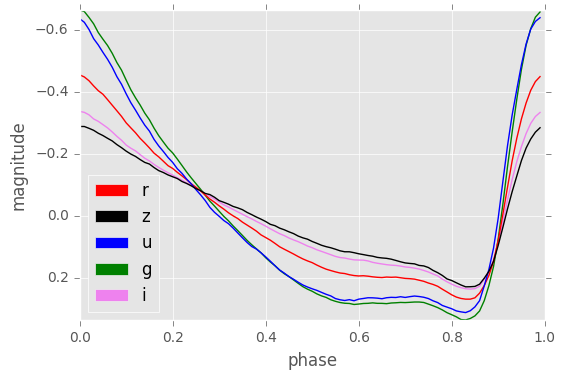

In [92]:
fig = plt.figure()
ax = plt.axes()
for ii in np.arange(len(filter_names)):
    ax.plot(t, tem_sdss[ii,:],color=cols[filter_names[ii]])
plt.ylim([np.max(tem_sdss),np.min(tem_sdss)])
plt.xlabel("phase")
plt.ylabel("magnitude");
recs = []
for i in cols.values():
    recs.append(mpatches.Rectangle((0,0),1,1,fc=i))

plt.legend(recs,cols.keys(),loc=3);

In the following section we describe how to fit the model with weighted least squares ("minimum $\chi^2$"). Directly using the inverse of the observation uncertainties as weights is known to be suboptimal when the templates are an approximation, see <strong data-cite="long2017">(Long, 2017)</strong>. We estimate a model error term $\sigma_{me}$ which is then used in the least square fitting. To compute $\sigma_{me}$, we fit the template to all well sampled RR Lyrae, compute the difference between the squared residuals and the squared photometric error $\sigma^2_{bi}$. $\sigma_{me}$ is the square root of the average of these differences. The value is:

In [93]:
print(r.tem_sdss.names[8])
print(r.tem_sdss[8])

model_error
         g          i          r          u          z 
0.05472967 0.05472967 0.05472967 0.05472967 0.05472967 



## Estimating Object Parameters

Code for fitting the template to an individual RR Lyrae is available at

`code/fit_template/fit_template.R`

In particular the workhorse function

`FitTemplate <- function(lc,omegas,tem,NN=5,use.errors=TRUE,use.dust=TRUE)`

computes the residual sum of squares at every frequency in `omegas` for light curve `lc` and template `tem`. See the implementation demos (`demo_R.ipynb` and `demo_python.ipynb`) for more about the implementation. Here we describe the numerical algorithm behind the code.

The model is fit with least squares and a grid search across the frequency parameter $\omega$. There are at most five free parameters $\mu$, $E[B-V]$, $a$, $\omega$, $\phi$. The dust can be turned off in the fitting in which case $E[B-V]$ is set to $0$.

Define $m'_{bt}(\omega) = m_{bt} - M_b(\omega)$. At frequency $\omega$ in the grid, we solve for the four parameters

$$ \min_{\mu,E[B-V],a,\phi} \sum_{b,t} \frac{(m'_{bt} - \mu - E[B-V]R_b - a\gamma_b(\omega t_{bt} + \phi))^2}{\sigma_{bt}^2 + \sigma_{me}^2}$$

We use a block--relaxation method in which we alternative between minimizing across the $(\mu,E[B-V],a)$ parameters and minimizing across the $\phi$ parameter. At fixed $\phi$, the model is linear in $(\mu,E[B-V],a)$ so the minimization is nearly trivial. Sometimes the update will result in a negative amplitude. In this case, we do a random phase update in the next step (i.e. draw phase uniformly in [0,1]), rather than the Newton method described below.   

Fixing $\mu,E[B-V],a$, we cannot analytically solve for $\phi$. Instead XXXX 

Consider using a newton like algorithm where
\begin{equation*}
\phi^{(m+1)} = \phi^{(m)} - H(g)^{-1}(\phi^{(m)})\nabla(g)(\phi^{(m)})
\end{equation*}
We need to compute $H(g)$ and $\nabla(g)$ (the first and second derivatives of $g$). We have
\begin{equation*}
\nabla(g) = \frac{\partial g}{\partial \phi} = - 2\sum \sum (m_{ib}' - \gamma_{bi}(\phi))\gamma_{bi}'(\phi).
\end{equation*}
and
\begin{equation*}
H(g) = \frac{\partial^2 g}{\partial \phi^2} = 2 \sum \sum \left(\gamma'_{bi}(\phi)^2 - (m_{ib}' - \gamma_{bi}(\phi))\gamma''_{bi}(\phi)\right)
\end{equation*}

For phase registration, Ramsey and Silverman (Functional Data Analysis Second Edition) recommend droppgin the second term in $H(g)$ and using
\begin{equation*}
H^*(g) = 2 \sum \sum \gamma'_{bi}(\phi)^2 
\end{equation*}
instead.


### References

Fitzpatrick 1999. "Correcting for the Effects of Interstellar Extinction." PASP

Long 2017. "A note on parameter estimation for misspecified regression models with heteroskedastic errors." Electronic Journal of Statistics.

Sesar 2010. "Light curve templates and galactic distribution of rr lyrae stars from sloan digital sky survey stripe 82." ApJ.